In [1]:
# First check location of python install
import sys
print(sys.executable)

# import pyam - IIASA provided package to manipulate IIASA database downloads
import pyam
# import other external packages to store data in an efficient way (pandas) and plot (matplotlib)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import numpy as np
from fair_scm import *
import scipy as sp

/Users/stuartjenkins/anaconda2/envs/python37/bin/python3


<IPython.core.display.Javascript object>

In [2]:
# import the datasets from subfolder "15_degree_compatible_scens_IIASA"
co2_ems_df = pyam.IamDataFrame(data='./15_degree_compatible_scens_IIASA/iamc15_snapshot_co2ems.xlsx', encoding='utf-8')
co2_RF_df = pyam.IamDataFrame(data='./15_degree_compatible_scens_IIASA/iamc15_snapshot_co2rf.xlsx', encoding='utf-8')
total_RF_df = pyam.IamDataFrame(data='./15_degree_compatible_scens_IIASA/iamc15_snapshot_totalrf.xlsx', encoding='utf-8')

# import RCP85 scenario to stitch onto past
RCP85_E = pd.read_csv('./RCP_data/RCP85_EMISSIONS.csv',skiprows=36,index_col=0)

RCP85_RF = pd.read_csv('./RCP_data/RCP85_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

INFO:root:Reading `./15_degree_compatible_scens_IIASA/iamc15_snapshot_co2ems.xlsx`
INFO:root:Reading `./15_degree_compatible_scens_IIASA/iamc15_snapshot_co2rf.xlsx`
INFO:root:Reading `./15_degree_compatible_scens_IIASA/iamc15_snapshot_totalrf.xlsx`


In [3]:
# co2_ems_df.filter(variable='Emissions|CO2', region='World').line_plot(legend=False)

# co2_RF_df.filter(variable='Forcing|CO2', region='World').line_plot(legend=False)

# total_RF_df.filter(variable='Forcing', region='World').line_plot(legend=False)

TCR:  1.75 K
ECS:  2.6 K
calculated TCRE:  1.456409443807346 K/TtC


(0, 400)

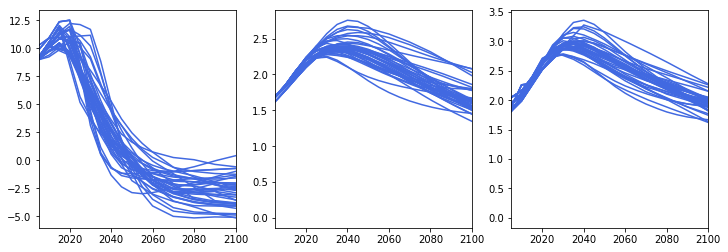

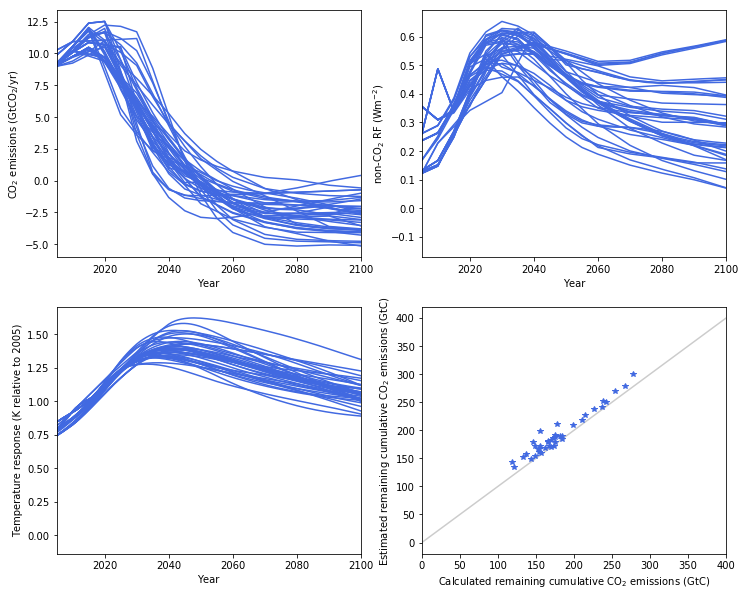

In [4]:
# what is the year we run the comparison from (chosen because we need 20 years of non-CO2 forcing data find F_0)
year_val = 2015
non_co2_forcing_average_over = 20

# Parameter values
full_index = np.arange(1765,2101)
TCR_val = 1.75
ECS_val = 2.6
d_array = np.array([239.0,4.1])
F_2x = 3.74
C_0 = 278.0
H = 100 # size of integration for AGWP calculation
input_yr = 10 # year of pulse CO2 injection to calc AGWP value
# produce pulse CO2 emissions timeseries
pulse_ems = np.zeros(150)
pulse_ems[input_yr] = 1000.
# run through FaIR with parameters (TCR,ECS,d,F_2x,C_0) as given above
C_pulse, T_pulse = fair_scm(emissions=pulse_ems, tcrecs=np.array([TCR_val,ECS_val]), d=d_array, C_0=C_0, F_2x=F_2x)
# calculate RF response from concentration response using log-relationship
RF_pulse = F_2x * np.log(C_pulse / C_0) / np.log(2)
# integrate for AGWP value in year H
AGWP = np.cumsum(RF_pulse)
# calculate TCRE value using formula in M. Allen et al.'s npj paper
TCRE = (TCR_val * AGWP[H+input_yr]) / (H * F_2x)

print('TCR: ',TCR_val,'K\nECS: ',ECS_val,'K\ncalculated TCRE: ', TCRE, 'K/TtC')


fig, ax = plt.subplots(1,3, figsize=(12,4))
fig1, ax1 = plt.subplots(2,2, figsize=(12,10))
ax1[1,1].plot([0,400],[0,400], color='black', alpha=0.2)
ax1[0,0].set_xlabel('Year')
ax1[0,0].set_ylabel('CO$_2$ emissions (GtCO$_2$/yr)')
ax1[0,1].set_xlabel('Year')
ax1[0,1].set_ylabel('non-CO$_2$ RF (Wm$^{-2}$)')
ax1[1,0].set_xlabel('Year')
ax1[1,0].set_ylabel('Temperature response (K relative to 2005)')
ax1[1,1].set_xlabel('Calculated remaining cumulative CO$_2$ emissions (GtC)')
ax1[1,1].set_ylabel('Estimated remaining cumulative CO$_2$ emissions (GtC)')

for i in range(0,len(list(co2_ems_df.models()))):
    co2_single_model = list(co2_ems_df.models())[i]
    rf_single_model = list(total_RF_df.models())[i]
    co2rf_single_model = list(co2_RF_df.models())[i]
    co2_one_model_df = co2_ems_df.filter(variable='Emissions|CO2', region='World', model=co2_single_model)
    rf_one_model_df = total_RF_df.filter(variable='Forcing', region='World', model=rf_single_model)
    co2rf_one_model_df = co2_RF_df.filter(variable='Forcing|CO2', region='World', model=co2rf_single_model)
    
    for j in range(0,len(list(co2_one_model_df.scenarios()))):
        co2_single_scenario = list(co2_one_model_df.scenarios())[j]
        rf_single_scenario = list(rf_one_model_df.scenarios())[j]
        co2rf_single_scenario = list(co2rf_one_model_df.scenarios())[j]
        co2_one_scenario_df = co2_one_model_df.filter(variable='Emissions|CO2', region='World', model=co2_single_model, scenario=co2_single_scenario)
        rf_one_scenario_df = rf_one_model_df.filter(variable='Forcing', region='World', model=rf_single_model, scenario=rf_single_scenario)
        co2rf_one_scenario_df = co2rf_one_model_df.filter(variable='Forcing|CO2', region='World', model=co2rf_single_model, scenario=co2rf_single_scenario)

        x_to_eval = np.arange(co2_one_scenario_df.as_pandas().year.values[0], co2_one_scenario_df.as_pandas().year.values[-1]+1)
        x_current = co2_one_scenario_df.as_pandas().year.values
        co2_y_current = co2_one_scenario_df.as_pandas().value.values
        rf_y_current = rf_one_scenario_df.as_pandas().value.values
        co2rf_y_current = co2rf_one_scenario_df.as_pandas().value.values

        co2_scenario_interp = np.interp(x_to_eval, x_current, co2_y_current)*12.0/44000.0
        rcp_co2_ems = RCP85_E.FossilCO2.loc[:x_to_eval[0]].values + RCP85_E.OtherCO2.loc[:x_to_eval[0]].values
        co2_scale_rcp = co2_scenario_interp[0] / rcp_co2_ems[-1]
        co2_ems_full = np.zeros(x_to_eval.size + rcp_co2_ems[:x_to_eval[0]-1765].size)
        co2_ems_full[:rcp_co2_ems.size] = rcp_co2_ems * co2_scale_rcp
        co2_ems_full[rcp_co2_ems.size-1:] = co2_scenario_interp

        if ('ADVANCE' in co2_single_scenario) & ('AIM' in co2_single_model):
            mask = np.array([True,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True])
            rf_scenario_interp = np.interp(x_to_eval, x_current[mask], rf_y_current[mask])
            rcp_rf = RCP85_RF.TOTAL_ANTHRO_RF.loc[:x_to_eval[0]].values
            rf_scale_rcp = rf_scenario_interp[0] / rcp_rf[-1]
            rf_full = np.zeros(x_to_eval.size + rcp_rf[:x_to_eval[0]-1765].size)
            rf_full[:rcp_rf.size] = rcp_rf * rf_scale_rcp
            rf_full[rcp_rf.size-1:] = rf_scenario_interp

            co2rf_scenario_interp = np.interp(x_to_eval, x_current[mask], co2rf_y_current[mask])
            rcp_co2rf = RCP85_RF.CO2_RF.loc[:x_to_eval[0]].values
            co2rf_scale_rcp = co2rf_scenario_interp[0] / rcp_co2rf[-1]
            co2rf_full = np.zeros(x_to_eval.size + rcp_co2rf[:x_to_eval[0]-1765].size)
            co2rf_full[:rcp_co2rf.size] = rcp_co2rf * co2rf_scale_rcp
            co2rf_full[rcp_co2rf.size-1:] = co2rf_scenario_interp
        else:
            rf_scenario_interp = np.interp(x_to_eval, x_current, rf_y_current)
            rcp_rf = RCP85_RF.TOTAL_ANTHRO_RF.loc[:x_to_eval[0]].values
            rf_scale_rcp = rf_scenario_interp[0] / rcp_rf[-1]
            rf_full = np.zeros(x_to_eval.size + rcp_rf[:x_to_eval[0]-1765].size)
            rf_full[:rcp_rf.size] = rcp_rf * rf_scale_rcp
            rf_full[rcp_rf.size-1:] = rf_scenario_interp

            co2rf_scenario_interp = np.interp(x_to_eval, x_current, co2rf_y_current)
            rcp_co2rf = RCP85_RF.CO2_RF.loc[:x_to_eval[0]].values
            co2rf_scale_rcp = co2rf_scenario_interp[0] / rcp_co2rf[-1]
            co2rf_full = np.zeros(x_to_eval.size + rcp_co2rf[:x_to_eval[0]-1765].size)
            co2rf_full[:rcp_co2rf.size] = rcp_co2rf * co2rf_scale_rcp
            co2rf_full[rcp_co2rf.size-1:] = co2rf_scenario_interp
                
#         rf_scenario_interp = np.interp(x_to_eval, x_current, rf_y_current)
#         rcp_rf = RCP85_RF.TOTAL_ANTHRO_RF.loc[:x_to_eval[0]].values
#         rf_scale_rcp = rf_scenario_interp[0] / rcp_rf[-1]
#         rf_full = np.zeros(x_to_eval.size + rcp_rf[:x_to_eval[0]-1765].size)
#         rf_full[:rcp_rf.size] = rcp_rf * rf_scale_rcp
#         rf_full[rcp_rf.size-1:] = rf_scenario_interp

#         co2rf_scenario_interp = np.interp(x_to_eval, x_current, co2rf_y_current)
#         rcp_co2rf = RCP85_RF.CO2_RF.loc[:x_to_eval[0]].values
#         co2rf_scale_rcp = co2rf_scenario_interp[0] / rcp_co2rf[-1]
#         co2rf_full = np.zeros(x_to_eval.size + rcp_co2rf[:x_to_eval[0]-1765].size)
#         co2rf_full[:rcp_co2rf.size] = rcp_co2rf * co2rf_scale_rcp
#         co2rf_full[rcp_co2rf.size-1:] = co2rf_scenario_interp

#         if 'ADVANCE' in co2_single_scenario:
#             if 'AIM' in co2_single_model:
#                 ax[0].plot(x_to_eval, co2_scenario_interp, color='red')
#                 ax[0].scatter(x_current, co2_y_current*12/44000, color='blue')
#                 ax[1].plot(x_to_eval, co2rf_scenario_interp, color='red')
#                 ax[1].scatter(x_current, co2rf_y_current, color='blue')
#                 ax[2].plot(x_to_eval, rf_scenario_interp, color='red')
#                 ax[2].scatter(x_current, rf_y_current, color='blue')

        ax[0].plot(np.arange(1765,2101), co2_ems_full, color='royalblue')
        ax[1].plot(np.arange(1765,2101), co2rf_full, color='royalblue')
        ax[2].plot(np.arange(1765,2101), rf_full, color='royalblue')
        
        
        
        
        
        
        # run each scenario through FaIR
        C_run, T_run = fair_scm(emissions=co2_ems_full, other_rf=rf_full-co2rf_full, tcrecs=np.array([TCR_val,ECS_val]), d=d_array)
        
        ax1[0,0].plot(full_index, co2_ems_full, color='royalblue')
        ax1[0,1].plot(full_index, rf_full - co2rf_full, color='royalblue')
        ax1[1,0].plot(full_index, T_run - np.mean(T_run[1850-1765:1901-1765]), color='royalblue')

        
        # find epsilon and carbon budget to temp peak
        non_co2rf_full = rf_full - co2rf_full
        temp_peak_val = np.max(T_run)
        year_of_temp_peak = full_index[T_run == temp_peak_val]
        epsilon = (ECS_val - TCR_val)/(TCR_val * d_array[0])
        
        F_1 = np.mean(non_co2rf_full[(full_index < year_of_temp_peak) * (full_index >= (year_of_temp_peak-non_co2_forcing_average_over))])
        F_0 = np.mean(non_co2rf_full[(full_index < year_val) * (full_index >= (year_val-non_co2_forcing_average_over))])
        
#         print(F_0, "\t", F_1)
#         print((epsilon * F_0 * (year_of_temp_peak-year_val))*H*1000/AGWP[H+input_yr])
        
        G_estimated = (((temp_peak_val-T_run[full_index == year_val]) / TCRE) - ((H * (F_1 - F_0 + epsilon*(year_of_temp_peak-full_index[year_val-full_index[0]])*F_0)) / (AGWP[H+input_yr])))*1000.
        
        G_calculated = np.sum(co2_ems_full[full_index<=year_of_temp_peak]) - np.sum(co2_ems_full[full_index<=year_val])
        
        ax1[1,1].plot(G_calculated, G_estimated, '*', color='royalblue')
            
ax[0].set_xlim(2005,2100)
ax[1].set_xlim(2005,2100)
ax[2].set_xlim(2005,2100)

ax1[0,0].set_xlim(2005,2100)
ax1[0,1].set_xlim(2005,2100)
ax1[1,0].set_xlim(2005,2100)
ax1[1,1].set_xlim(0,400)

# fig1.savefig('2025_20yrAverage.pdf', dpi=300)

TCR:  1.75 K
ECS:  2.6 K
calculated TCRE:  1.456409443807346 K/TtC


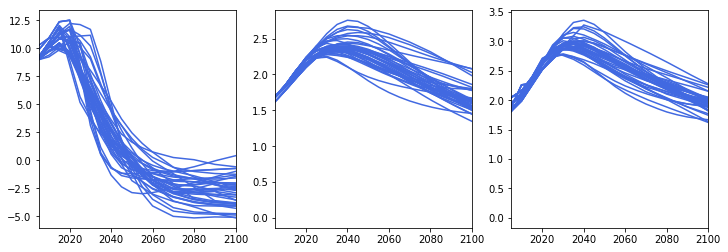

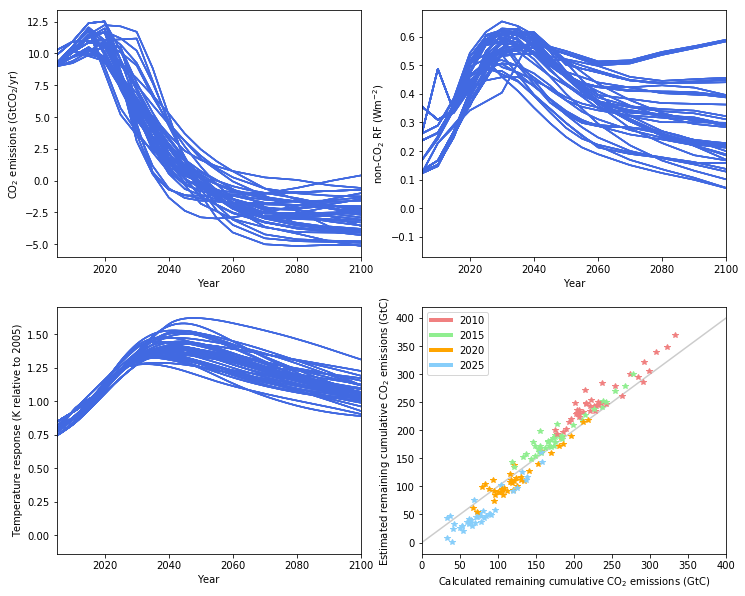

In [5]:
# what is the year we run the comparison from (chosen because we need 20 years of non-CO2 forcing data find F_0)
# year_val = 2015
colors=['lightcoral','lightgreen','orange','lightskyblue']
non_co2_forcing_average_over = 20

# Parameter values
full_index = np.arange(1765,2101)
TCR_val = 1.75
ECS_val = 2.6
d_array = np.array([239.0,4.1])
F_2x = 3.74
C_0 = 278.0
H = 100 # size of integration for AGWP calculation
input_yr = 10 # year of pulse CO2 injection to calc AGWP value
# produce pulse CO2 emissions timeseries
pulse_ems = np.zeros(150)
pulse_ems[input_yr] = 1000.
# run through FaIR with parameters (TCR,ECS,d,F_2x,C_0) as given above
C_pulse, T_pulse = fair_scm(emissions=pulse_ems, tcrecs=np.array([TCR_val,ECS_val]), d=d_array, C_0=C_0, F_2x=F_2x)
# calculate RF response from concentration response using log-relationship
RF_pulse = F_2x * np.log(C_pulse / C_0) / np.log(2)
# integrate for AGWP value in year H
AGWP = np.cumsum(RF_pulse)
# calculate TCRE value using formula in M. Allen et al.'s npj paper
TCRE = (TCR_val * AGWP[H+input_yr]) / (H * F_2x)

print('TCR: ',TCR_val,'K\nECS: ',ECS_val,'K\ncalculated TCRE: ', TCRE, 'K/TtC')

fig, ax = plt.subplots(1,3, figsize=(12,4))
fig1, ax1 = plt.subplots(2,2, figsize=(12,10))
ax1[1,1].plot([0,400],[0,400], color='black', alpha=0.2)
ax1[0,0].set_xlabel('Year')
ax1[0,0].set_ylabel('CO$_2$ emissions (GtCO$_2$/yr)')
ax1[0,1].set_xlabel('Year')
ax1[0,1].set_ylabel('non-CO$_2$ RF (Wm$^{-2}$)')
ax1[1,0].set_xlabel('Year')
ax1[1,0].set_ylabel('Temperature response (K relative to 2005)')
ax1[1,1].set_xlabel('Calculated remaining cumulative CO$_2$ emissions (GtC)')
ax1[1,1].set_ylabel('Estimated remaining cumulative CO$_2$ emissions (GtC)')

for i in range(0,len(list(co2_ems_df.models()))):
    co2_single_model = list(co2_ems_df.models())[i]
    rf_single_model = list(total_RF_df.models())[i]
    co2rf_single_model = list(co2_RF_df.models())[i]
    co2_one_model_df = co2_ems_df.filter(variable='Emissions|CO2', region='World', model=co2_single_model)
    rf_one_model_df = total_RF_df.filter(variable='Forcing', region='World', model=rf_single_model)
    co2rf_one_model_df = co2_RF_df.filter(variable='Forcing|CO2', region='World', model=co2rf_single_model)
    
    for j in range(0,len(list(co2_one_model_df.scenarios()))):
        co2_single_scenario = list(co2_one_model_df.scenarios())[j]
        rf_single_scenario = list(rf_one_model_df.scenarios())[j]
        co2rf_single_scenario = list(co2rf_one_model_df.scenarios())[j]
        co2_one_scenario_df = co2_one_model_df.filter(variable='Emissions|CO2', region='World', model=co2_single_model, scenario=co2_single_scenario)
        rf_one_scenario_df = rf_one_model_df.filter(variable='Forcing', region='World', model=rf_single_model, scenario=rf_single_scenario)
        co2rf_one_scenario_df = co2rf_one_model_df.filter(variable='Forcing|CO2', region='World', model=co2rf_single_model, scenario=co2rf_single_scenario)

        x_to_eval = np.arange(co2_one_scenario_df.as_pandas().year.values[0], co2_one_scenario_df.as_pandas().year.values[-1]+1)
        x_current = co2_one_scenario_df.as_pandas().year.values
        co2_y_current = co2_one_scenario_df.as_pandas().value.values
        rf_y_current = rf_one_scenario_df.as_pandas().value.values
        co2rf_y_current = co2rf_one_scenario_df.as_pandas().value.values

        co2_scenario_interp = np.interp(x_to_eval, x_current, co2_y_current)*12.0/44000.0
        rcp_co2_ems = RCP85_E.FossilCO2.loc[:x_to_eval[0]].values + RCP85_E.OtherCO2.loc[:x_to_eval[0]].values
        co2_scale_rcp = co2_scenario_interp[0] / rcp_co2_ems[-1]
        co2_ems_full = np.zeros(x_to_eval.size + rcp_co2_ems[:x_to_eval[0]-1765].size)
        co2_ems_full[:rcp_co2_ems.size] = rcp_co2_ems * co2_scale_rcp
        co2_ems_full[rcp_co2_ems.size-1:] = co2_scenario_interp

        if ('ADVANCE' in co2_single_scenario) & ('AIM' in co2_single_model):
            mask = np.array([True,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True])
            rf_scenario_interp = np.interp(x_to_eval, x_current[mask], rf_y_current[mask])
            rcp_rf = RCP85_RF.TOTAL_ANTHRO_RF.loc[:x_to_eval[0]].values
            rf_scale_rcp = rf_scenario_interp[0] / rcp_rf[-1]
            rf_full = np.zeros(x_to_eval.size + rcp_rf[:x_to_eval[0]-1765].size)
            rf_full[:rcp_rf.size] = rcp_rf * rf_scale_rcp
            rf_full[rcp_rf.size-1:] = rf_scenario_interp

            co2rf_scenario_interp = np.interp(x_to_eval, x_current[mask], co2rf_y_current[mask])
            rcp_co2rf = RCP85_RF.CO2_RF.loc[:x_to_eval[0]].values
            co2rf_scale_rcp = co2rf_scenario_interp[0] / rcp_co2rf[-1]
            co2rf_full = np.zeros(x_to_eval.size + rcp_co2rf[:x_to_eval[0]-1765].size)
            co2rf_full[:rcp_co2rf.size] = rcp_co2rf * co2rf_scale_rcp
            co2rf_full[rcp_co2rf.size-1:] = co2rf_scenario_interp
        else:
            rf_scenario_interp = np.interp(x_to_eval, x_current, rf_y_current)
            rcp_rf = RCP85_RF.TOTAL_ANTHRO_RF.loc[:x_to_eval[0]].values
            rf_scale_rcp = rf_scenario_interp[0] / rcp_rf[-1]
            rf_full = np.zeros(x_to_eval.size + rcp_rf[:x_to_eval[0]-1765].size)
            rf_full[:rcp_rf.size] = rcp_rf * rf_scale_rcp
            rf_full[rcp_rf.size-1:] = rf_scenario_interp

            co2rf_scenario_interp = np.interp(x_to_eval, x_current, co2rf_y_current)
            rcp_co2rf = RCP85_RF.CO2_RF.loc[:x_to_eval[0]].values
            co2rf_scale_rcp = co2rf_scenario_interp[0] / rcp_co2rf[-1]
            co2rf_full = np.zeros(x_to_eval.size + rcp_co2rf[:x_to_eval[0]-1765].size)
            co2rf_full[:rcp_co2rf.size] = rcp_co2rf * co2rf_scale_rcp
            co2rf_full[rcp_co2rf.size-1:] = co2rf_scenario_interp

        ax[0].plot(np.arange(1765,2101), co2_ems_full, color='royalblue')
        ax[1].plot(np.arange(1765,2101), co2rf_full, color='royalblue')
        ax[2].plot(np.arange(1765,2101), rf_full, color='royalblue')
        
        
        
        
        for i,year_val in enumerate(range(2010,2026,5)):
        
            # run each scenario through FaIR
            C_run, T_run = fair_scm(emissions=co2_ems_full, other_rf=rf_full-co2rf_full, tcrecs=np.array([TCR_val,ECS_val]), d=d_array)

            ax1[0,0].plot(full_index, co2_ems_full, color='royalblue')
            ax1[0,1].plot(full_index, rf_full - co2rf_full, color='royalblue')
            ax1[1,0].plot(full_index, T_run - np.mean(T_run[1850-1765:1901-1765]), color='royalblue')


            # find epsilon and carbon budget to temp peak
            non_co2rf_full = rf_full - co2rf_full
            temp_peak_val = np.max(T_run)
            year_of_temp_peak = full_index[T_run == temp_peak_val]
            epsilon = (ECS_val - TCR_val)/(TCR_val * d_array[0])

            F_1 = np.mean(non_co2rf_full[(full_index < year_of_temp_peak) * (full_index >= (year_of_temp_peak-non_co2_forcing_average_over))])
            F_0 = np.mean(non_co2rf_full[(full_index < year_val) * (full_index >= (year_val-non_co2_forcing_average_over))])

    #         print(F_0, "\t", F_1)
    #         print((epsilon * F_0 * (year_of_temp_peak-year_val))*H*1000/AGWP[H+input_yr])

            G_estimated = (((temp_peak_val-T_run[full_index == year_val]) / TCRE) - ((H * (F_1 - F_0 + epsilon*(year_of_temp_peak-full_index[year_val-full_index[0]])*F_0)) / (AGWP[H+input_yr])))*1000.

            G_calculated = np.sum(co2_ems_full[full_index<=year_of_temp_peak]) - np.sum(co2_ems_full[full_index<=year_val])

            ax1[1,1].plot(G_calculated, G_estimated, '*', color=colors[i])
            
ax[0].set_xlim(2005,2100)
ax[1].set_xlim(2005,2100)
ax[2].set_xlim(2005,2100)

ax1[0,0].set_xlim(2005,2100)
ax1[0,1].set_xlim(2005,2100)
ax1[1,0].set_xlim(2005,2100)
ax1[1,1].set_xlim(0,400)

custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                Line2D([0], [0], color=colors[1], lw=4),
                Line2D([0], [0], color=colors[2], lw=4),
                Line2D([0], [0], color=colors[3], lw=4)]
ax1[1,1].legend(custom_lines, ['2010', '2015', '2020', '2025'])

# fig1.savefig('2010to25_20yrAverage.pdf', dpi=300)

TCR:  1.75 K
ECS:  2.6 K
calculated TCRE:  1.456409443807346 K/TtC


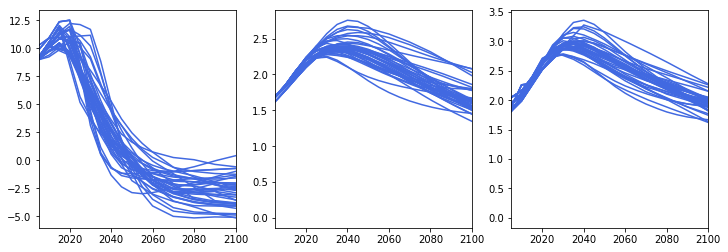

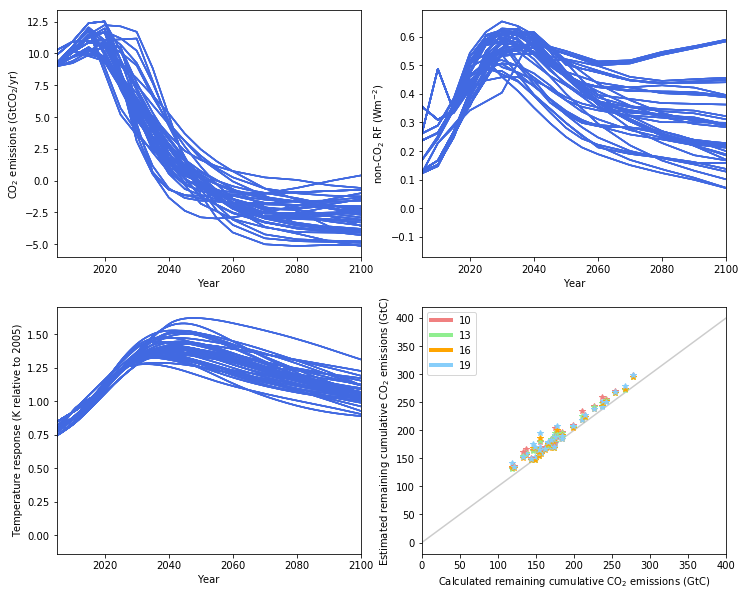

In [6]:
# what is the year we run the comparison from (chosen because we need 20 years of non-CO2 forcing data find F_0)
year_val = 2015
colors=['lightcoral','lightgreen','orange','lightskyblue']
# non_co2_forcing_average_over = 20

# Parameter values
full_index = np.arange(1765,2101)
TCR_val = 1.75
ECS_val = 2.6
d_array = np.array([239.0,4.1])
F_2x = 3.74
C_0 = 278.0
H = 100 # size of integration for AGWP calculation
input_yr = 10 # year of pulse CO2 injection to calc AGWP value
# produce pulse CO2 emissions timeseries
pulse_ems = np.zeros(150)
pulse_ems[input_yr] = 1000.
# run through FaIR with parameters (TCR,ECS,d,F_2x,C_0) as given above
C_pulse, T_pulse = fair_scm(emissions=pulse_ems, tcrecs=np.array([TCR_val,ECS_val]), d=d_array, C_0=C_0, F_2x=F_2x)
# calculate RF response from concentration response using log-relationship
RF_pulse = F_2x * np.log(C_pulse / C_0) / np.log(2)
# integrate for AGWP value in year H
AGWP = np.cumsum(RF_pulse)
# calculate TCRE value using formula in M. Allen et al.'s npj paper
TCRE = (TCR_val * AGWP[H+input_yr]) / (H * F_2x)

print('TCR: ',TCR_val,'K\nECS: ',ECS_val,'K\ncalculated TCRE: ', TCRE, 'K/TtC')

fig, ax = plt.subplots(1,3, figsize=(12,4))
fig1, ax1 = plt.subplots(2,2, figsize=(12,10))
ax1[1,1].plot([0,400],[0,400], color='black', alpha=0.2)
ax1[0,0].set_xlabel('Year')
ax1[0,0].set_ylabel('CO$_2$ emissions (GtCO$_2$/yr)')
ax1[0,1].set_xlabel('Year')
ax1[0,1].set_ylabel('non-CO$_2$ RF (Wm$^{-2}$)')
ax1[1,0].set_xlabel('Year')
ax1[1,0].set_ylabel('Temperature response (K relative to 2005)')
ax1[1,1].set_xlabel('Calculated remaining cumulative CO$_2$ emissions (GtC)')
ax1[1,1].set_ylabel('Estimated remaining cumulative CO$_2$ emissions (GtC)')

for i in range(0,len(list(co2_ems_df.models()))):
    co2_single_model = list(co2_ems_df.models())[i]
    rf_single_model = list(total_RF_df.models())[i]
    co2rf_single_model = list(co2_RF_df.models())[i]
    co2_one_model_df = co2_ems_df.filter(variable='Emissions|CO2', region='World', model=co2_single_model)
    rf_one_model_df = total_RF_df.filter(variable='Forcing', region='World', model=rf_single_model)
    co2rf_one_model_df = co2_RF_df.filter(variable='Forcing|CO2', region='World', model=co2rf_single_model)
    
    for j in range(0,len(list(co2_one_model_df.scenarios()))):
        co2_single_scenario = list(co2_one_model_df.scenarios())[j]
        rf_single_scenario = list(rf_one_model_df.scenarios())[j]
        co2rf_single_scenario = list(co2rf_one_model_df.scenarios())[j]
        co2_one_scenario_df = co2_one_model_df.filter(variable='Emissions|CO2', region='World', model=co2_single_model, scenario=co2_single_scenario)
        rf_one_scenario_df = rf_one_model_df.filter(variable='Forcing', region='World', model=rf_single_model, scenario=rf_single_scenario)
        co2rf_one_scenario_df = co2rf_one_model_df.filter(variable='Forcing|CO2', region='World', model=co2rf_single_model, scenario=co2rf_single_scenario)

        x_to_eval = np.arange(co2_one_scenario_df.as_pandas().year.values[0], co2_one_scenario_df.as_pandas().year.values[-1]+1)
        x_current = co2_one_scenario_df.as_pandas().year.values
        co2_y_current = co2_one_scenario_df.as_pandas().value.values
        rf_y_current = rf_one_scenario_df.as_pandas().value.values
        co2rf_y_current = co2rf_one_scenario_df.as_pandas().value.values

        co2_scenario_interp = np.interp(x_to_eval, x_current, co2_y_current)*12.0/44000.0
        rcp_co2_ems = RCP85_E.FossilCO2.loc[:x_to_eval[0]].values + RCP85_E.OtherCO2.loc[:x_to_eval[0]].values
        co2_scale_rcp = co2_scenario_interp[0] / rcp_co2_ems[-1]
        co2_ems_full = np.zeros(x_to_eval.size + rcp_co2_ems[:x_to_eval[0]-1765].size)
        co2_ems_full[:rcp_co2_ems.size] = rcp_co2_ems * co2_scale_rcp
        co2_ems_full[rcp_co2_ems.size-1:] = co2_scenario_interp

        if ('ADVANCE' in co2_single_scenario) & ('AIM' in co2_single_model):
            mask = np.array([True,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True])
            rf_scenario_interp = np.interp(x_to_eval, x_current[mask], rf_y_current[mask])
            rcp_rf = RCP85_RF.TOTAL_ANTHRO_RF.loc[:x_to_eval[0]].values
            rf_scale_rcp = rf_scenario_interp[0] / rcp_rf[-1]
            rf_full = np.zeros(x_to_eval.size + rcp_rf[:x_to_eval[0]-1765].size)
            rf_full[:rcp_rf.size] = rcp_rf * rf_scale_rcp
            rf_full[rcp_rf.size-1:] = rf_scenario_interp

            co2rf_scenario_interp = np.interp(x_to_eval, x_current[mask], co2rf_y_current[mask])
            rcp_co2rf = RCP85_RF.CO2_RF.loc[:x_to_eval[0]].values
            co2rf_scale_rcp = co2rf_scenario_interp[0] / rcp_co2rf[-1]
            co2rf_full = np.zeros(x_to_eval.size + rcp_co2rf[:x_to_eval[0]-1765].size)
            co2rf_full[:rcp_co2rf.size] = rcp_co2rf * co2rf_scale_rcp
            co2rf_full[rcp_co2rf.size-1:] = co2rf_scenario_interp
        else:
            rf_scenario_interp = np.interp(x_to_eval, x_current, rf_y_current)
            rcp_rf = RCP85_RF.TOTAL_ANTHRO_RF.loc[:x_to_eval[0]].values
            rf_scale_rcp = rf_scenario_interp[0] / rcp_rf[-1]
            rf_full = np.zeros(x_to_eval.size + rcp_rf[:x_to_eval[0]-1765].size)
            rf_full[:rcp_rf.size] = rcp_rf * rf_scale_rcp
            rf_full[rcp_rf.size-1:] = rf_scenario_interp

            co2rf_scenario_interp = np.interp(x_to_eval, x_current, co2rf_y_current)
            rcp_co2rf = RCP85_RF.CO2_RF.loc[:x_to_eval[0]].values
            co2rf_scale_rcp = co2rf_scenario_interp[0] / rcp_co2rf[-1]
            co2rf_full = np.zeros(x_to_eval.size + rcp_co2rf[:x_to_eval[0]-1765].size)
            co2rf_full[:rcp_co2rf.size] = rcp_co2rf * co2rf_scale_rcp
            co2rf_full[rcp_co2rf.size-1:] = co2rf_scenario_interp

        ax[0].plot(np.arange(1765,2101), co2_ems_full, color='royalblue')
        ax[1].plot(np.arange(1765,2101), co2rf_full, color='royalblue')
        ax[2].plot(np.arange(1765,2101), rf_full, color='royalblue')
        
        
        
        
        for i,non_co2_forcing_average_over in enumerate(range(10,21,3)):
        
            # run each scenario through FaIR
            C_run, T_run = fair_scm(emissions=co2_ems_full, other_rf=rf_full-co2rf_full, tcrecs=np.array([TCR_val,ECS_val]), d=d_array)

            ax1[0,0].plot(full_index, co2_ems_full, color='royalblue')
            ax1[0,1].plot(full_index, rf_full - co2rf_full, color='royalblue')
            ax1[1,0].plot(full_index, T_run - np.mean(T_run[1850-1765:1901-1765]), color='royalblue')


            # find epsilon and carbon budget to temp peak
            non_co2rf_full = rf_full - co2rf_full
            temp_peak_val = np.max(T_run)
            year_of_temp_peak = full_index[T_run == temp_peak_val]
            epsilon = (ECS_val - TCR_val)/(TCR_val * d_array[0])

            F_1 = np.mean(non_co2rf_full[(full_index < year_of_temp_peak) * (full_index >= (year_of_temp_peak-non_co2_forcing_average_over))])
            F_0 = np.mean(non_co2rf_full[(full_index < year_val) * (full_index >= (year_val-non_co2_forcing_average_over))])

    #         print(F_0, "\t", F_1)
    #         print((epsilon * F_0 * (year_of_temp_peak-year_val))*H*1000/AGWP[H+input_yr])

            G_estimated = (((temp_peak_val-T_run[full_index == year_val]) / TCRE) - ((H * (F_1 - F_0 + epsilon*(year_of_temp_peak-full_index[year_val-full_index[0]])*F_0)) / (AGWP[H+input_yr])))*1000.

            G_calculated = np.sum(co2_ems_full[full_index<=year_of_temp_peak]) - np.sum(co2_ems_full[full_index<=year_val])

            ax1[1,1].plot(G_calculated, G_estimated, '*', color=colors[i])
            
ax[0].set_xlim(2005,2100)
ax[1].set_xlim(2005,2100)
ax[2].set_xlim(2005,2100)

ax1[0,0].set_xlim(2005,2100)
ax1[0,1].set_xlim(2005,2100)
ax1[1,0].set_xlim(2005,2100)
ax1[1,1].set_xlim(0,400)

custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                Line2D([0], [0], color=colors[1], lw=4),
                Line2D([0], [0], color=colors[2], lw=4),
                Line2D([0], [0], color=colors[3], lw=4)]
ax1[1,1].legend(custom_lines, ['10', '13', '16', '19'])

# fig1.savefig('2015_10to20yrAverage.pdf', dpi=300)

TCR:  2.5 K
ECS:  2.6 K
calculated TCRE:  2.1540773490838374 K/TtC
TCR:  2.0 K
ECS:  2.6 K
calculated TCRE:  1.6840435802829554 K/TtC
TCR:  1.5 K
ECS:  2.6 K
calculated TCRE:  1.233714400514205 K/TtC
TCR:  1.0 K
ECS:  2.6 K
calculated TCRE:  0.803114055086807 K/TtC


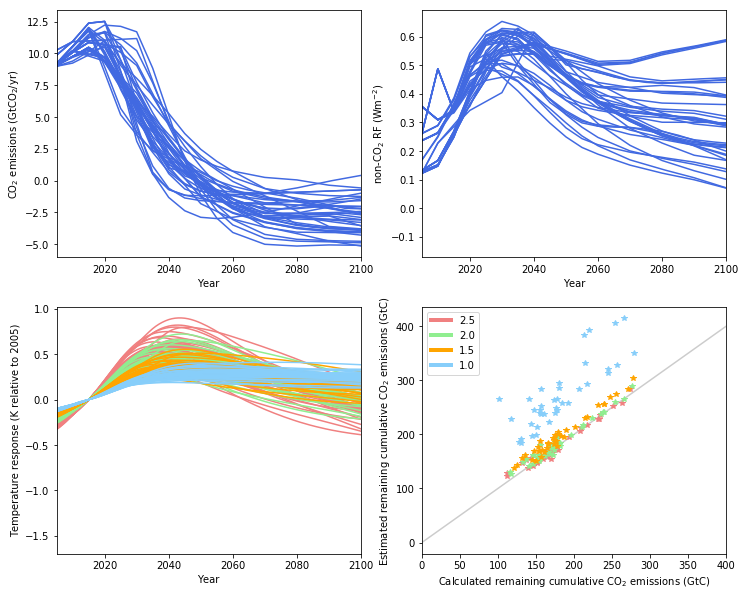

In [7]:
# what is the year we run the comparison from (chosen because we need 20 years of non-CO2 forcing data find F_0)
year_val = 2015
colors=['lightcoral','lightgreen','orange','lightskyblue']
non_co2_forcing_average_over = 15

fig1, ax1 = plt.subplots(2,2, figsize=(12,10))
ax1[1,1].plot([0,400],[0,400], color='black', alpha=0.2)
ax1[0,0].set_xlabel('Year')
ax1[0,0].set_ylabel('CO$_2$ emissions (GtCO$_2$/yr)')
ax1[0,1].set_xlabel('Year')
ax1[0,1].set_ylabel('non-CO$_2$ RF (Wm$^{-2}$)')
ax1[1,0].set_xlabel('Year')
ax1[1,0].set_ylabel('Temperature response (K relative to 2005)')
ax1[1,1].set_xlabel('Calculated remaining cumulative CO$_2$ emissions (GtC)')
ax1[1,1].set_ylabel('Estimated remaining cumulative CO$_2$ emissions (GtC)')

for k,TCR_val in enumerate(np.array([2.5,2.0,1.5,1.0])):
    # Parameter values
    full_index = np.arange(1765,2101)
    ECS_val = 2.6
    d_array = np.array([239.0,4.1])
    F_2x = 3.74
    C_0 = 278.0
    H = 100 # size of integration for AGWP calculation
    input_yr = 10 # year of pulse CO2 injection to calc AGWP value
    # produce pulse CO2 emissions timeseries
    pulse_ems = np.zeros(150)
    pulse_ems[input_yr] = 1000.
    # run through FaIR with parameters (TCR,ECS,d,F_2x,C_0) as given above
    C_pulse, T_pulse = fair_scm(emissions=pulse_ems, tcrecs=np.array([TCR_val,ECS_val]), d=d_array, C_0=C_0, F_2x=F_2x)
    # calculate RF response from concentration response using log-relationship
    RF_pulse = F_2x * np.log(C_pulse / C_0) / np.log(2)
    # integrate for AGWP value in year H
    AGWP = np.cumsum(RF_pulse)
    # calculate TCRE value using formula in M. Allen et al.'s npj paper
    TCRE = (TCR_val * AGWP[H+input_yr]) / (H * F_2x)

    print('TCR: ',TCR_val,'K\nECS: ',ECS_val,'K\ncalculated TCRE: ', TCRE, 'K/TtC')

    for i in range(0,len(list(co2_ems_df.models()))):
        co2_single_model = list(co2_ems_df.models())[i]
        rf_single_model = list(total_RF_df.models())[i]
        co2rf_single_model = list(co2_RF_df.models())[i]
        co2_one_model_df = co2_ems_df.filter(variable='Emissions|CO2', region='World', model=co2_single_model)
        rf_one_model_df = total_RF_df.filter(variable='Forcing', region='World', model=rf_single_model)
        co2rf_one_model_df = co2_RF_df.filter(variable='Forcing|CO2', region='World', model=co2rf_single_model)

        for j in range(0,len(list(co2_one_model_df.scenarios()))):
            co2_single_scenario = list(co2_one_model_df.scenarios())[j]
            rf_single_scenario = list(rf_one_model_df.scenarios())[j]
            co2rf_single_scenario = list(co2rf_one_model_df.scenarios())[j]
            co2_one_scenario_df = co2_one_model_df.filter(variable='Emissions|CO2', region='World', model=co2_single_model, scenario=co2_single_scenario)
            rf_one_scenario_df = rf_one_model_df.filter(variable='Forcing', region='World', model=rf_single_model, scenario=rf_single_scenario)
            co2rf_one_scenario_df = co2rf_one_model_df.filter(variable='Forcing|CO2', region='World', model=co2rf_single_model, scenario=co2rf_single_scenario)

            x_to_eval = np.arange(co2_one_scenario_df.as_pandas().year.values[0], co2_one_scenario_df.as_pandas().year.values[-1]+1)
            x_current = co2_one_scenario_df.as_pandas().year.values
            co2_y_current = co2_one_scenario_df.as_pandas().value.values
            rf_y_current = rf_one_scenario_df.as_pandas().value.values
            co2rf_y_current = co2rf_one_scenario_df.as_pandas().value.values

            co2_scenario_interp = np.interp(x_to_eval, x_current, co2_y_current)*12.0/44000.0
            rcp_co2_ems = RCP85_E.FossilCO2.loc[:x_to_eval[0]].values + RCP85_E.OtherCO2.loc[:x_to_eval[0]].values
            co2_scale_rcp = co2_scenario_interp[0] / rcp_co2_ems[-1]
            co2_ems_full = np.zeros(x_to_eval.size + rcp_co2_ems[:x_to_eval[0]-1765].size)
            co2_ems_full[:rcp_co2_ems.size] = rcp_co2_ems * co2_scale_rcp
            co2_ems_full[rcp_co2_ems.size-1:] = co2_scenario_interp

            if ('ADVANCE' in co2_single_scenario) & ('AIM' in co2_single_model):
                mask = np.array([True,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True])
                rf_scenario_interp = np.interp(x_to_eval, x_current[mask], rf_y_current[mask])
                rcp_rf = RCP85_RF.TOTAL_ANTHRO_RF.loc[:x_to_eval[0]].values
                rf_scale_rcp = rf_scenario_interp[0] / rcp_rf[-1]
                rf_full = np.zeros(x_to_eval.size + rcp_rf[:x_to_eval[0]-1765].size)
                rf_full[:rcp_rf.size] = rcp_rf * rf_scale_rcp
                rf_full[rcp_rf.size-1:] = rf_scenario_interp

                co2rf_scenario_interp = np.interp(x_to_eval, x_current[mask], co2rf_y_current[mask])
                rcp_co2rf = RCP85_RF.CO2_RF.loc[:x_to_eval[0]].values
                co2rf_scale_rcp = co2rf_scenario_interp[0] / rcp_co2rf[-1]
                co2rf_full = np.zeros(x_to_eval.size + rcp_co2rf[:x_to_eval[0]-1765].size)
                co2rf_full[:rcp_co2rf.size] = rcp_co2rf * co2rf_scale_rcp
                co2rf_full[rcp_co2rf.size-1:] = co2rf_scenario_interp
            else:
                rf_scenario_interp = np.interp(x_to_eval, x_current, rf_y_current)
                rcp_rf = RCP85_RF.TOTAL_ANTHRO_RF.loc[:x_to_eval[0]].values
                rf_scale_rcp = rf_scenario_interp[0] / rcp_rf[-1]
                rf_full = np.zeros(x_to_eval.size + rcp_rf[:x_to_eval[0]-1765].size)
                rf_full[:rcp_rf.size] = rcp_rf * rf_scale_rcp
                rf_full[rcp_rf.size-1:] = rf_scenario_interp

                co2rf_scenario_interp = np.interp(x_to_eval, x_current, co2rf_y_current)
                rcp_co2rf = RCP85_RF.CO2_RF.loc[:x_to_eval[0]].values
                co2rf_scale_rcp = co2rf_scenario_interp[0] / rcp_co2rf[-1]
                co2rf_full = np.zeros(x_to_eval.size + rcp_co2rf[:x_to_eval[0]-1765].size)
                co2rf_full[:rcp_co2rf.size] = rcp_co2rf * co2rf_scale_rcp
                co2rf_full[rcp_co2rf.size-1:] = co2rf_scenario_interp

                # run each scenario through FaIR
                C_run, T_run = fair_scm(emissions=co2_ems_full, other_rf=rf_full-co2rf_full, tcrecs=np.array([TCR_val,ECS_val]), d=d_array)
                
                if TCR_val == 1.0:
                    ax1[0,0].plot(full_index, co2_ems_full, color='royalblue')
                    ax1[0,1].plot(full_index, rf_full - co2rf_full, color='royalblue')
                ax1[1,0].plot(full_index, T_run - np.mean(T_run[year_val-1765]), color=colors[k])

                # find epsilon and carbon budget to temp peak
                non_co2rf_full = rf_full - co2rf_full
                temp_peak_val = np.max(T_run)
                year_of_temp_peak = full_index[T_run == temp_peak_val]
                epsilon = (ECS_val - TCR_val)/(TCR_val * d_array[0])

                F_1 = np.mean(non_co2rf_full[(full_index < year_of_temp_peak) * (full_index >= (year_of_temp_peak-non_co2_forcing_average_over))])
                F_0 = np.mean(non_co2rf_full[(full_index < year_val) * (full_index >= (year_val-non_co2_forcing_average_over))])

        #         print(F_0, "\t", F_1)
        #         print((epsilon * F_0 * (year_of_temp_peak-year_val))*H*1000/AGWP[H+input_yr])

                G_estimated = (((temp_peak_val-T_run[full_index == year_val]) / TCRE) - ((H * (F_1 - F_0 + epsilon*(year_of_temp_peak-full_index[year_val-full_index[0]])*F_0)) / (AGWP[H+input_yr])))*1000.

                G_calculated = np.sum(co2_ems_full[full_index<=year_of_temp_peak]) - np.sum(co2_ems_full[full_index<=year_val])

                ax1[1,1].plot(G_calculated, G_estimated, '*', color=colors[k])
            
ax[0].set_xlim(2005,2100)
ax[1].set_xlim(2005,2100)
ax[2].set_xlim(2005,2100)

ax1[0,0].set_xlim(2005,2100)
ax1[0,1].set_xlim(2005,2100)
ax1[1,0].set_xlim(2005,2100)
ax1[1,1].set_xlim(0,400)

custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                Line2D([0], [0], color=colors[1], lw=4),
                Line2D([0], [0], color=colors[2], lw=4),
                Line2D([0], [0], color=colors[3], lw=4)]
ax1[1,1].legend(custom_lines, ['2.5', '2.0', '1.5', '1.0'])

# fig1.savefig('2015_15yrAverage_vary_TCR.pdf', dpi=300)

TCR:  1.75 K
ECS:  1.75 K
calculated TCRE:  1.458468047995596 K/TtC
TCR:  1.75 K
ECS:  2.5 K
calculated TCRE:  1.4566574030655337 K/TtC
TCR:  1.75 K
ECS:  3.5 K
calculated TCRE:  1.4541098884263481 K/TtC
TCR:  1.75 K
ECS:  4.5 K
calculated TCRE:  1.4514147022643353 K/TtC


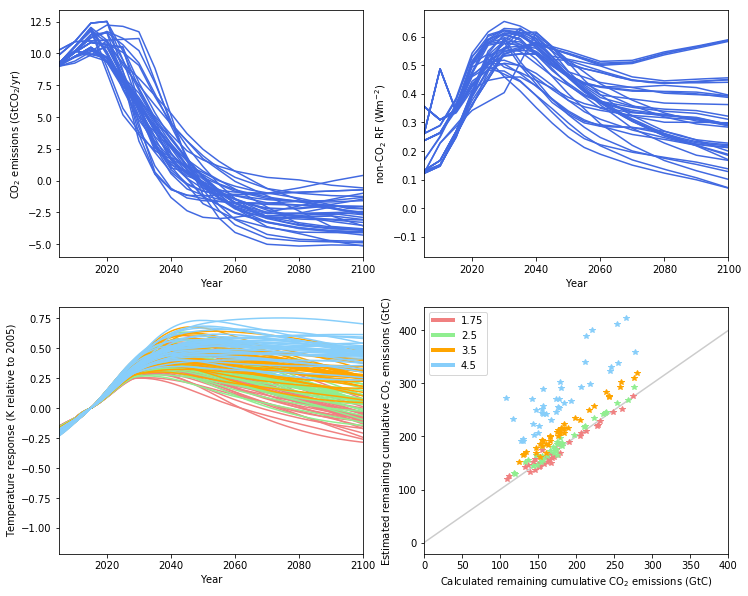

In [8]:
# what is the year we run the comparison from (chosen because we need 20 years of non-CO2 forcing data find F_0)
year_val = 2015
colors=['lightcoral','lightgreen','orange','lightskyblue']
non_co2_forcing_average_over = 15

fig1, ax1 = plt.subplots(2,2, figsize=(12,10))
ax1[1,1].plot([0,400],[0,400], color='black', alpha=0.2)
ax1[0,0].set_xlabel('Year')
ax1[0,0].set_ylabel('CO$_2$ emissions (GtCO$_2$/yr)')
ax1[0,1].set_xlabel('Year')
ax1[0,1].set_ylabel('non-CO$_2$ RF (Wm$^{-2}$)')
ax1[1,0].set_xlabel('Year')
ax1[1,0].set_ylabel('Temperature response (K relative to 2005)')
ax1[1,1].set_xlabel('Calculated remaining cumulative CO$_2$ emissions (GtC)')
ax1[1,1].set_ylabel('Estimated remaining cumulative CO$_2$ emissions (GtC)')

for k,ECS_val in enumerate(np.array([1.75,2.5,3.5,4.5])):
    # Parameter values
    full_index = np.arange(1765,2101)
    TCR_val=1.75
    d_array = np.array([239.0,4.1])
    F_2x = 3.74
    C_0 = 278.0
    H = 100 # size of integration for AGWP calculation
    input_yr = 10 # year of pulse CO2 injection to calc AGWP value
    # produce pulse CO2 emissions timeseries
    pulse_ems = np.zeros(150)
    pulse_ems[input_yr] = 1000.
    # run through FaIR with parameters (TCR,ECS,d,F_2x,C_0) as given above
    C_pulse, T_pulse = fair_scm(emissions=pulse_ems, tcrecs=np.array([TCR_val,ECS_val]), d=d_array, C_0=C_0, F_2x=F_2x)
    # calculate RF response from concentration response using log-relationship
    RF_pulse = F_2x * np.log(C_pulse / C_0) / np.log(2)
    # integrate for AGWP value in year H
    AGWP = np.cumsum(RF_pulse)
    # calculate TCRE value using formula in M. Allen et al.'s npj paper
    TCRE = (TCR_val * AGWP[H+input_yr]) / (H * F_2x)

    print('TCR: ',TCR_val,'K\nECS: ',ECS_val,'K\ncalculated TCRE: ', TCRE, 'K/TtC')

    for i in range(0,len(list(co2_ems_df.models()))):
        co2_single_model = list(co2_ems_df.models())[i]
        rf_single_model = list(total_RF_df.models())[i]
        co2rf_single_model = list(co2_RF_df.models())[i]
        co2_one_model_df = co2_ems_df.filter(variable='Emissions|CO2', region='World', model=co2_single_model)
        rf_one_model_df = total_RF_df.filter(variable='Forcing', region='World', model=rf_single_model)
        co2rf_one_model_df = co2_RF_df.filter(variable='Forcing|CO2', region='World', model=co2rf_single_model)

        for j in range(0,len(list(co2_one_model_df.scenarios()))):
            co2_single_scenario = list(co2_one_model_df.scenarios())[j]
            rf_single_scenario = list(rf_one_model_df.scenarios())[j]
            co2rf_single_scenario = list(co2rf_one_model_df.scenarios())[j]
            co2_one_scenario_df = co2_one_model_df.filter(variable='Emissions|CO2', region='World', model=co2_single_model, scenario=co2_single_scenario)
            rf_one_scenario_df = rf_one_model_df.filter(variable='Forcing', region='World', model=rf_single_model, scenario=rf_single_scenario)
            co2rf_one_scenario_df = co2rf_one_model_df.filter(variable='Forcing|CO2', region='World', model=co2rf_single_model, scenario=co2rf_single_scenario)

            x_to_eval = np.arange(co2_one_scenario_df.as_pandas().year.values[0], co2_one_scenario_df.as_pandas().year.values[-1]+1)
            x_current = co2_one_scenario_df.as_pandas().year.values
            co2_y_current = co2_one_scenario_df.as_pandas().value.values
            rf_y_current = rf_one_scenario_df.as_pandas().value.values
            co2rf_y_current = co2rf_one_scenario_df.as_pandas().value.values

            co2_scenario_interp = np.interp(x_to_eval, x_current, co2_y_current)*12.0/44000.0
            rcp_co2_ems = RCP85_E.FossilCO2.loc[:x_to_eval[0]].values + RCP85_E.OtherCO2.loc[:x_to_eval[0]].values
            co2_scale_rcp = co2_scenario_interp[0] / rcp_co2_ems[-1]
            co2_ems_full = np.zeros(x_to_eval.size + rcp_co2_ems[:x_to_eval[0]-1765].size)
            co2_ems_full[:rcp_co2_ems.size] = rcp_co2_ems * co2_scale_rcp
            co2_ems_full[rcp_co2_ems.size-1:] = co2_scenario_interp

            if ('ADVANCE' in co2_single_scenario) & ('AIM' in co2_single_model):
                mask = np.array([True,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True])
                rf_scenario_interp = np.interp(x_to_eval, x_current[mask], rf_y_current[mask])
                rcp_rf = RCP85_RF.TOTAL_ANTHRO_RF.loc[:x_to_eval[0]].values
                rf_scale_rcp = rf_scenario_interp[0] / rcp_rf[-1]
                rf_full = np.zeros(x_to_eval.size + rcp_rf[:x_to_eval[0]-1765].size)
                rf_full[:rcp_rf.size] = rcp_rf * rf_scale_rcp
                rf_full[rcp_rf.size-1:] = rf_scenario_interp

                co2rf_scenario_interp = np.interp(x_to_eval, x_current[mask], co2rf_y_current[mask])
                rcp_co2rf = RCP85_RF.CO2_RF.loc[:x_to_eval[0]].values
                co2rf_scale_rcp = co2rf_scenario_interp[0] / rcp_co2rf[-1]
                co2rf_full = np.zeros(x_to_eval.size + rcp_co2rf[:x_to_eval[0]-1765].size)
                co2rf_full[:rcp_co2rf.size] = rcp_co2rf * co2rf_scale_rcp
                co2rf_full[rcp_co2rf.size-1:] = co2rf_scenario_interp
            else:
                rf_scenario_interp = np.interp(x_to_eval, x_current, rf_y_current)
                rcp_rf = RCP85_RF.TOTAL_ANTHRO_RF.loc[:x_to_eval[0]].values
                rf_scale_rcp = rf_scenario_interp[0] / rcp_rf[-1]
                rf_full = np.zeros(x_to_eval.size + rcp_rf[:x_to_eval[0]-1765].size)
                rf_full[:rcp_rf.size] = rcp_rf * rf_scale_rcp
                rf_full[rcp_rf.size-1:] = rf_scenario_interp

                co2rf_scenario_interp = np.interp(x_to_eval, x_current, co2rf_y_current)
                rcp_co2rf = RCP85_RF.CO2_RF.loc[:x_to_eval[0]].values
                co2rf_scale_rcp = co2rf_scenario_interp[0] / rcp_co2rf[-1]
                co2rf_full = np.zeros(x_to_eval.size + rcp_co2rf[:x_to_eval[0]-1765].size)
                co2rf_full[:rcp_co2rf.size] = rcp_co2rf * co2rf_scale_rcp
                co2rf_full[rcp_co2rf.size-1:] = co2rf_scenario_interp

                # run each scenario through FaIR
                C_run, T_run = fair_scm(emissions=co2_ems_full, other_rf=rf_full-co2rf_full, tcrecs=np.array([TCR_val,ECS_val]), d=d_array)
                
                if ECS_val == 2.5:
                    ax1[0,0].plot(full_index, co2_ems_full, color='royalblue')
                    ax1[0,1].plot(full_index, rf_full - co2rf_full, color='royalblue')
                ax1[1,0].plot(full_index, T_run - np.mean(T_run[year_val-1765]), color=colors[k])

                # find epsilon and carbon budget to temp peak
                non_co2rf_full = rf_full - co2rf_full
                temp_peak_val = np.max(T_run)
                year_of_temp_peak = full_index[T_run == temp_peak_val]
                epsilon = (ECS_val - TCR_val)/(TCR_val * d_array[0])

                F_1 = np.mean(non_co2rf_full[(full_index < year_of_temp_peak) * (full_index >= (year_of_temp_peak-non_co2_forcing_average_over))])
                F_0 = np.mean(non_co2rf_full[(full_index < year_val) * (full_index >= (year_val-non_co2_forcing_average_over))])

        #         print(F_0, "\t", F_1)
        #         print((epsilon * F_0 * (year_of_temp_peak-year_val))*H*1000/AGWP[H+input_yr])

                G_estimated = (((temp_peak_val-T_run[full_index == year_val]) / TCRE) - ((H * (F_1 - F_0 + epsilon*(year_of_temp_peak-full_index[year_val-full_index[0]])*F_0)) / (AGWP[H+input_yr])))*1000.

                G_calculated = np.sum(co2_ems_full[full_index<=year_of_temp_peak]) - np.sum(co2_ems_full[full_index<=year_val])

                ax1[1,1].plot(G_calculated, G_estimated, '*', color=colors[k])
            
ax[0].set_xlim(2005,2100)
ax[1].set_xlim(2005,2100)
ax[2].set_xlim(2005,2100)

ax1[0,0].set_xlim(2005,2100)
ax1[0,1].set_xlim(2005,2100)
ax1[1,0].set_xlim(2005,2100)
ax1[1,1].set_xlim(0,400)

custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                Line2D([0], [0], color=colors[1], lw=4),
                Line2D([0], [0], color=colors[2], lw=4),
                Line2D([0], [0], color=colors[3], lw=4)]
ax1[1,1].legend(custom_lines, ['1.75', '2.5', '3.5', '4.5'])

# fig1.savefig('2015_15yrAverage_vary_ECS.pdf', dpi=300)

TCR:  1.0 K
ECS:  1.5 K
calculated TCRE:  0.8047146902428277 K/TtC
TCR:  1.5 K
ECS:  2.5 K
calculated TCRE:  1.2339323200339338 K/TtC
TCR:  2.0 K
ECS:  3.5 K
calculated TCRE:  1.6814925041945847 K/TtC
TCR:  2.5 K
ECS:  4.5 K
calculated TCRE:  2.1476218780441787 K/TtC


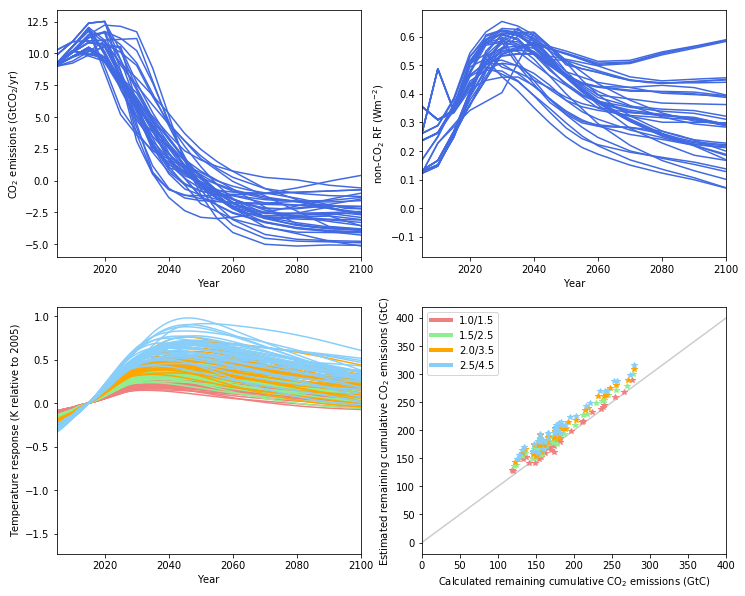

In [16]:
# what is the year we run the comparison from (chosen because we need 20 years of non-CO2 forcing data find F_0)
year_val = 2015
colors=['lightcoral','lightgreen','orange','lightskyblue']
non_co2_forcing_average_over = 15

fig1, ax1 = plt.subplots(2,2, figsize=(12,10))
ax1[1,1].plot([0,400],[0,400], color='black', alpha=0.2)
ax1[0,0].set_xlabel('Year')
ax1[0,0].set_ylabel('CO$_2$ emissions (GtCO$_2$/yr)')
ax1[0,1].set_xlabel('Year')
ax1[0,1].set_ylabel('non-CO$_2$ RF (Wm$^{-2}$)')
ax1[1,0].set_xlabel('Year')
ax1[1,0].set_ylabel('Temperature response (K relative to 2005)')
ax1[1,1].set_xlabel('Calculated remaining cumulative CO$_2$ emissions (GtC)')
ax1[1,1].set_ylabel('Estimated remaining cumulative CO$_2$ emissions (GtC)')

TCRs = np.array([1.0,1.5,2.0,2.5])

for k,ECS_val in enumerate(np.array([1.5,2.5,3.5,4.5])):
    # Parameter values
    full_index = np.arange(1765,2101)
    TCR_val=TCRs[k]
    d_array = np.array([239.0,4.1])
    F_2x = 3.74
    C_0 = 278.0
    H = 100 # size of integration for AGWP calculation
    input_yr = 10 # year of pulse CO2 injection to calc AGWP value
    # produce pulse CO2 emissions timeseries
    pulse_ems = np.zeros(150)
    pulse_ems[input_yr] = 1000.
    # run through FaIR with parameters (TCR,ECS,d,F_2x,C_0) as given above
    C_pulse, T_pulse = fair_scm(emissions=pulse_ems, tcrecs=np.array([TCR_val,ECS_val]), d=d_array, C_0=C_0, F_2x=F_2x)
    # calculate RF response from concentration response using log-relationship
    RF_pulse = F_2x * np.log(C_pulse / C_0) / np.log(2)
    # integrate for AGWP value in year H
    AGWP = np.cumsum(RF_pulse)
    # calculate TCRE value using formula in M. Allen et al.'s npj paper
    TCRE = (TCR_val * AGWP[H+input_yr]) / (H * F_2x)

    print('TCR: ',TCR_val,'K\nECS: ',ECS_val,'K\ncalculated TCRE: ', TCRE, 'K/TtC')

    for i in range(0,len(list(co2_ems_df.models()))):
        co2_single_model = list(co2_ems_df.models())[i]
        rf_single_model = list(total_RF_df.models())[i]
        co2rf_single_model = list(co2_RF_df.models())[i]
        co2_one_model_df = co2_ems_df.filter(variable='Emissions|CO2', region='World', model=co2_single_model)
        rf_one_model_df = total_RF_df.filter(variable='Forcing', region='World', model=rf_single_model)
        co2rf_one_model_df = co2_RF_df.filter(variable='Forcing|CO2', region='World', model=co2rf_single_model)

        for j in range(0,len(list(co2_one_model_df.scenarios()))):
            co2_single_scenario = list(co2_one_model_df.scenarios())[j]
            rf_single_scenario = list(rf_one_model_df.scenarios())[j]
            co2rf_single_scenario = list(co2rf_one_model_df.scenarios())[j]
            co2_one_scenario_df = co2_one_model_df.filter(variable='Emissions|CO2', region='World', model=co2_single_model, scenario=co2_single_scenario)
            rf_one_scenario_df = rf_one_model_df.filter(variable='Forcing', region='World', model=rf_single_model, scenario=rf_single_scenario)
            co2rf_one_scenario_df = co2rf_one_model_df.filter(variable='Forcing|CO2', region='World', model=co2rf_single_model, scenario=co2rf_single_scenario)

            x_to_eval = np.arange(co2_one_scenario_df.as_pandas().year.values[0], co2_one_scenario_df.as_pandas().year.values[-1]+1)
            x_current = co2_one_scenario_df.as_pandas().year.values
            co2_y_current = co2_one_scenario_df.as_pandas().value.values
            rf_y_current = rf_one_scenario_df.as_pandas().value.values
            co2rf_y_current = co2rf_one_scenario_df.as_pandas().value.values

            co2_scenario_interp = np.interp(x_to_eval, x_current, co2_y_current)*12.0/44000.0
            rcp_co2_ems = RCP85_E.FossilCO2.loc[:x_to_eval[0]].values + RCP85_E.OtherCO2.loc[:x_to_eval[0]].values
            co2_scale_rcp = co2_scenario_interp[0] / rcp_co2_ems[-1]
            co2_ems_full = np.zeros(x_to_eval.size + rcp_co2_ems[:x_to_eval[0]-1765].size)
            co2_ems_full[:rcp_co2_ems.size] = rcp_co2_ems * co2_scale_rcp
            co2_ems_full[rcp_co2_ems.size-1:] = co2_scenario_interp

            if ('ADVANCE' in co2_single_scenario) & ('AIM' in co2_single_model):
                mask = np.array([True,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True])
                rf_scenario_interp = np.interp(x_to_eval, x_current[mask], rf_y_current[mask])
                rcp_rf = RCP85_RF.TOTAL_ANTHRO_RF.loc[:x_to_eval[0]].values
                rf_scale_rcp = rf_scenario_interp[0] / rcp_rf[-1]
                rf_full = np.zeros(x_to_eval.size + rcp_rf[:x_to_eval[0]-1765].size)
                rf_full[:rcp_rf.size] = rcp_rf * rf_scale_rcp
                rf_full[rcp_rf.size-1:] = rf_scenario_interp

                co2rf_scenario_interp = np.interp(x_to_eval, x_current[mask], co2rf_y_current[mask])
                rcp_co2rf = RCP85_RF.CO2_RF.loc[:x_to_eval[0]].values
                co2rf_scale_rcp = co2rf_scenario_interp[0] / rcp_co2rf[-1]
                co2rf_full = np.zeros(x_to_eval.size + rcp_co2rf[:x_to_eval[0]-1765].size)
                co2rf_full[:rcp_co2rf.size] = rcp_co2rf * co2rf_scale_rcp
                co2rf_full[rcp_co2rf.size-1:] = co2rf_scenario_interp
            else:
                rf_scenario_interp = np.interp(x_to_eval, x_current, rf_y_current)
                rcp_rf = RCP85_RF.TOTAL_ANTHRO_RF.loc[:x_to_eval[0]].values
                rf_scale_rcp = rf_scenario_interp[0] / rcp_rf[-1]
                rf_full = np.zeros(x_to_eval.size + rcp_rf[:x_to_eval[0]-1765].size)
                rf_full[:rcp_rf.size] = rcp_rf * rf_scale_rcp
                rf_full[rcp_rf.size-1:] = rf_scenario_interp

                co2rf_scenario_interp = np.interp(x_to_eval, x_current, co2rf_y_current)
                rcp_co2rf = RCP85_RF.CO2_RF.loc[:x_to_eval[0]].values
                co2rf_scale_rcp = co2rf_scenario_interp[0] / rcp_co2rf[-1]
                co2rf_full = np.zeros(x_to_eval.size + rcp_co2rf[:x_to_eval[0]-1765].size)
                co2rf_full[:rcp_co2rf.size] = rcp_co2rf * co2rf_scale_rcp
                co2rf_full[rcp_co2rf.size-1:] = co2rf_scenario_interp

                # run each scenario through FaIR
                C_run, T_run = fair_scm(emissions=co2_ems_full, other_rf=rf_full-co2rf_full, tcrecs=np.array([TCR_val,ECS_val]), d=d_array)
                
                if ECS_val == 2.5:
                    ax1[0,0].plot(full_index, co2_ems_full, color='royalblue')
                    ax1[0,1].plot(full_index, rf_full - co2rf_full, color='royalblue')
                ax1[1,0].plot(full_index, T_run - np.mean(T_run[year_val-1765]), color=colors[k])

                # find epsilon and carbon budget to temp peak
                non_co2rf_full = rf_full - co2rf_full
                temp_peak_val = np.max(T_run)
                year_of_temp_peak = full_index[T_run == temp_peak_val]
                epsilon = (ECS_val - TCR_val)/(TCR_val * d_array[0])

                F_1 = np.mean(non_co2rf_full[(full_index < year_of_temp_peak) * (full_index >= (year_of_temp_peak-non_co2_forcing_average_over))])
                F_0 = np.mean(non_co2rf_full[(full_index < year_val) * (full_index >= (year_val-non_co2_forcing_average_over))])

        #         print(F_0, "\t", F_1)
        #         print((epsilon * F_0 * (year_of_temp_peak-year_val))*H*1000/AGWP[H+input_yr])

                G_estimated = (((temp_peak_val-T_run[full_index == year_val]) / TCRE) - ((H * (F_1 - F_0 + epsilon*(year_of_temp_peak-full_index[year_val-full_index[0]])*F_0)) / (AGWP[H+input_yr])))*1000.

                G_calculated = np.sum(co2_ems_full[full_index<=year_of_temp_peak]) - np.sum(co2_ems_full[full_index<=year_val])

                ax1[1,1].plot(G_calculated, G_estimated, '*', color=colors[k])

ax[0].set_xlim(2005,2100)
ax[1].set_xlim(2005,2100)
ax[2].set_xlim(2005,2100)

ax1[0,0].set_xlim(2005,2100)
ax1[0,1].set_xlim(2005,2100)
ax1[1,0].set_xlim(2005,2100)
ax1[1,1].set_xlim(0,400)

custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                Line2D([0], [0], color=colors[1], lw=4),
                Line2D([0], [0], color=colors[2], lw=4),
                Line2D([0], [0], color=colors[3], lw=4)]
ax1[1,1].legend(custom_lines, ['1.0/1.5', '1.5/2.5', '2.0/3.5', '2.5/4.5'])

# fig1.savefig('2015_15yrAverage_covary_TCR_ECS.pdf', dpi=300)